In [1]:
import os
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

In [2]:
skill_scores_long = pd.read_csv('./results/raven_nse_skill/skill_scores.csv')

gauge_info= pd.read_csv('../SMM_Models/hype/geospatial/misc/hype_naturalized_flows_summary.csv', index_col=0)

output_dir = './results/raven_nse_skill/'

plot_prefix = 'raven_nse'

# Define periods and corresponding masks
periods = {
    'calibration': 'cal_mask',
    'validation': 'val_mask',
 #   'all': None  # No mask for 'all'
}

In [3]:
# Create dictionary mapping subbasin_id to Gauge ID
subbasin_to_gauge = gauge_info['Gauge ID'].to_dict()

# Make sure subbasin column is int
skill_scores_long['subbasin'] = skill_scores_long['subbasin'].astype(int)

# Ensure dictionary keys are int
subbasin_to_gauge = {int(k): v for k, v in subbasin_to_gauge.items()}

# Map gauge IDs
skill_scores_long['gauge_id'] = skill_scores_long['subbasin'].map(subbasin_to_gauge)


In [4]:
# ================
# Sort from West to East
# Ensure subbasin_id is the index in gauge_info
gauge_info_sorted = gauge_info.reset_index().sort_values("Longitude")

# Create a dictionary mapping gauge_id to longitude
gauge_order = gauge_info_sorted["Gauge ID"].tolist()

# Make gauge_id categorical in skill_scores_long with the correct order
skill_scores_long['gauge_id'] = pd.Categorical(
    skill_scores_long['gauge_id'],
    categories=gauge_order,
    ordered=True
)

# Optional: sort the DataFrame by gauge_id for plotting
skill_scores_long = skill_scores_long.sort_values(['gauge_id', 'period', 'benchmark']).reset_index(drop=True)


In [5]:
# # CB-friendly colours
# box_color = "#ADD8E6"  # lighter blue
# lowest_benchmark_color = "#E69F00"  # orange
# mean_flow_color = "#009E73"         # green
# top_benchmark_color = "#CC79A7"  # magenta/purple

# # Publication-quality settings
# sns.set_style("whitegrid")
# plt.rcParams.update({
#     'font.size': 10,
#     'axes.titlesize': 12,
#     'axes.labelsize': 9,
#     'xtick.labelsize': 8,
#     'ytick.labelsize': 8,
#     'legend.fontsize': 9
# })

# # Create subplots: 3 rows, 1 column (calibration, validation, all)
# fig, axes = plt.subplots(len(periods), 1, figsize=(9, 8), dpi=300, sharex=True, sharey=False)

# for i, period in enumerate(periods):
#     df_period = skill_scores_long[skill_scores_long['period'] == period].copy()
#     df_period['gauge_id'] = pd.Categorical(df_period['gauge_id'], categories=df_period['gauge_id'].unique(), ordered=True)

#     # --- Existing boxplot ---
#     sns.boxplot(
#         x='gauge_id',
#         y='skill_score',
#         data=df_period,
#         ax=axes[i],
#         color=box_color,
#         width=0.6,
#         fliersize=3
#     )

#     # --- Lowest benchmark (orange dot) ---
#     min_rows = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmin()]
#     x_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0] for gid in min_rows['gauge_id']]
#     axes[i].scatter(
#         x=x_positions,
#         y=min_rows["skill_score"],
#         color=lowest_benchmark_color,
#         s=30,
#         zorder=5
#     )

#     # --- Mean flow benchmark (green square) ---
#     mean_rows = df_period[df_period['benchmark'] == 'bm_mean_flow']
#     x_mean_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0] for gid in mean_rows['gauge_id']]
#     axes[i].scatter(
#         x=x_mean_positions,
#         y=mean_rows["skill_score"],
#         color=mean_flow_color,
#         s=30,
#         zorder=5,
#         marker='s'
#     )

#     # --- NEW: Top benchmark (purple dot) ---
#     max_rows = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmax()]
#     x_max_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0] for gid in max_rows['gauge_id']]
#     axes[i].scatter(
#         x=x_max_positions,
#         y=max_rows["skill_score"],
#         color=top_benchmark_color,
#         s=30,
#         zorder=5,
#         marker='o'
#     )

#     # Horizontal line at y=0
#     axes[i].axhline(0, color='red', linestyle='--', linewidth=1)

#     # Set y-axis limits
#     y_min = df_period['skill_score'].min() - 0.32
#     y_max = 1
#     axes[i].set_ylim(y_min, y_max)

# # --- Annotate lowest benchmark (below dot) ---
#     for row, x_pos in zip(min_rows.itertuples(), x_positions):
#         label_text = row.benchmark.replace("bm_", "").replace("_", "\n")
#         value_text = f"{row.skill_score:.2g}"
#         axes[i].annotate(
#             f"{label_text}:\n{value_text}",
#             (x_pos, row.skill_score),
#             textcoords="offset points",
#             xytext=(0, -15),  # below dot
#             ha="center",
#             va="top",
#             fontsize=6,
#             color="black",
#             bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=0.2, alpha=1)
#         )
    
#     # --- Annotate top benchmark (above dot) ---
#     for row, x_pos in zip(max_rows.itertuples(), x_max_positions):
#         label_text = row.benchmark.replace("bm_", "").replace("_", "\n")
#         value_text = f"{row.skill_score:.2g}"
#         axes[i].annotate(
#             f"{label_text}:\n{value_text}",
#             (x_pos, row.skill_score),
#             textcoords="offset points",
#             xytext=(0, 10),  # above dot
#             ha="center",
#             va="bottom",
#             fontsize=6,
#             color="black",
#             bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=0.2, alpha=1)
#         )

#     axes[i].set_title(
#     f'Skill Scores: {period.capitalize()}',
#     fontsize=12,
#     weight='bold',
#     pad=40   # default is 6, increase to push title away from plot
#     )
#     axes[i].set_ylabel('Skill Score', fontsize=10)
#     axes[i].tick_params(axis='x', rotation=45)

# axes[-1].set_xlabel('Gauge ID', fontsize=10)

# # Update legend with new top benchmark
# fig.legend(
#     handles=[
#         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lowest_benchmark_color, markersize=6, label='Lowest benchmark'),
#         plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=mean_flow_color, markersize=6, label='NSE (Mean Flow Benchmark)'),
#         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=top_benchmark_color, markersize=6, label='Top benchmark')
#     ],
#     loc="lower center",
#     ncol=3,
#     frameon=False
# )

# plt.tight_layout(rect=[0, 0.05, 1, 1])

# # Save figures
# plt.savefig(os.path.join(output_dir, 'skill_scores_boxplot.pdf'), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(output_dir, 'skill_scores_boxplot.png'), dpi=300, bbox_inches="tight")

# plt.show()

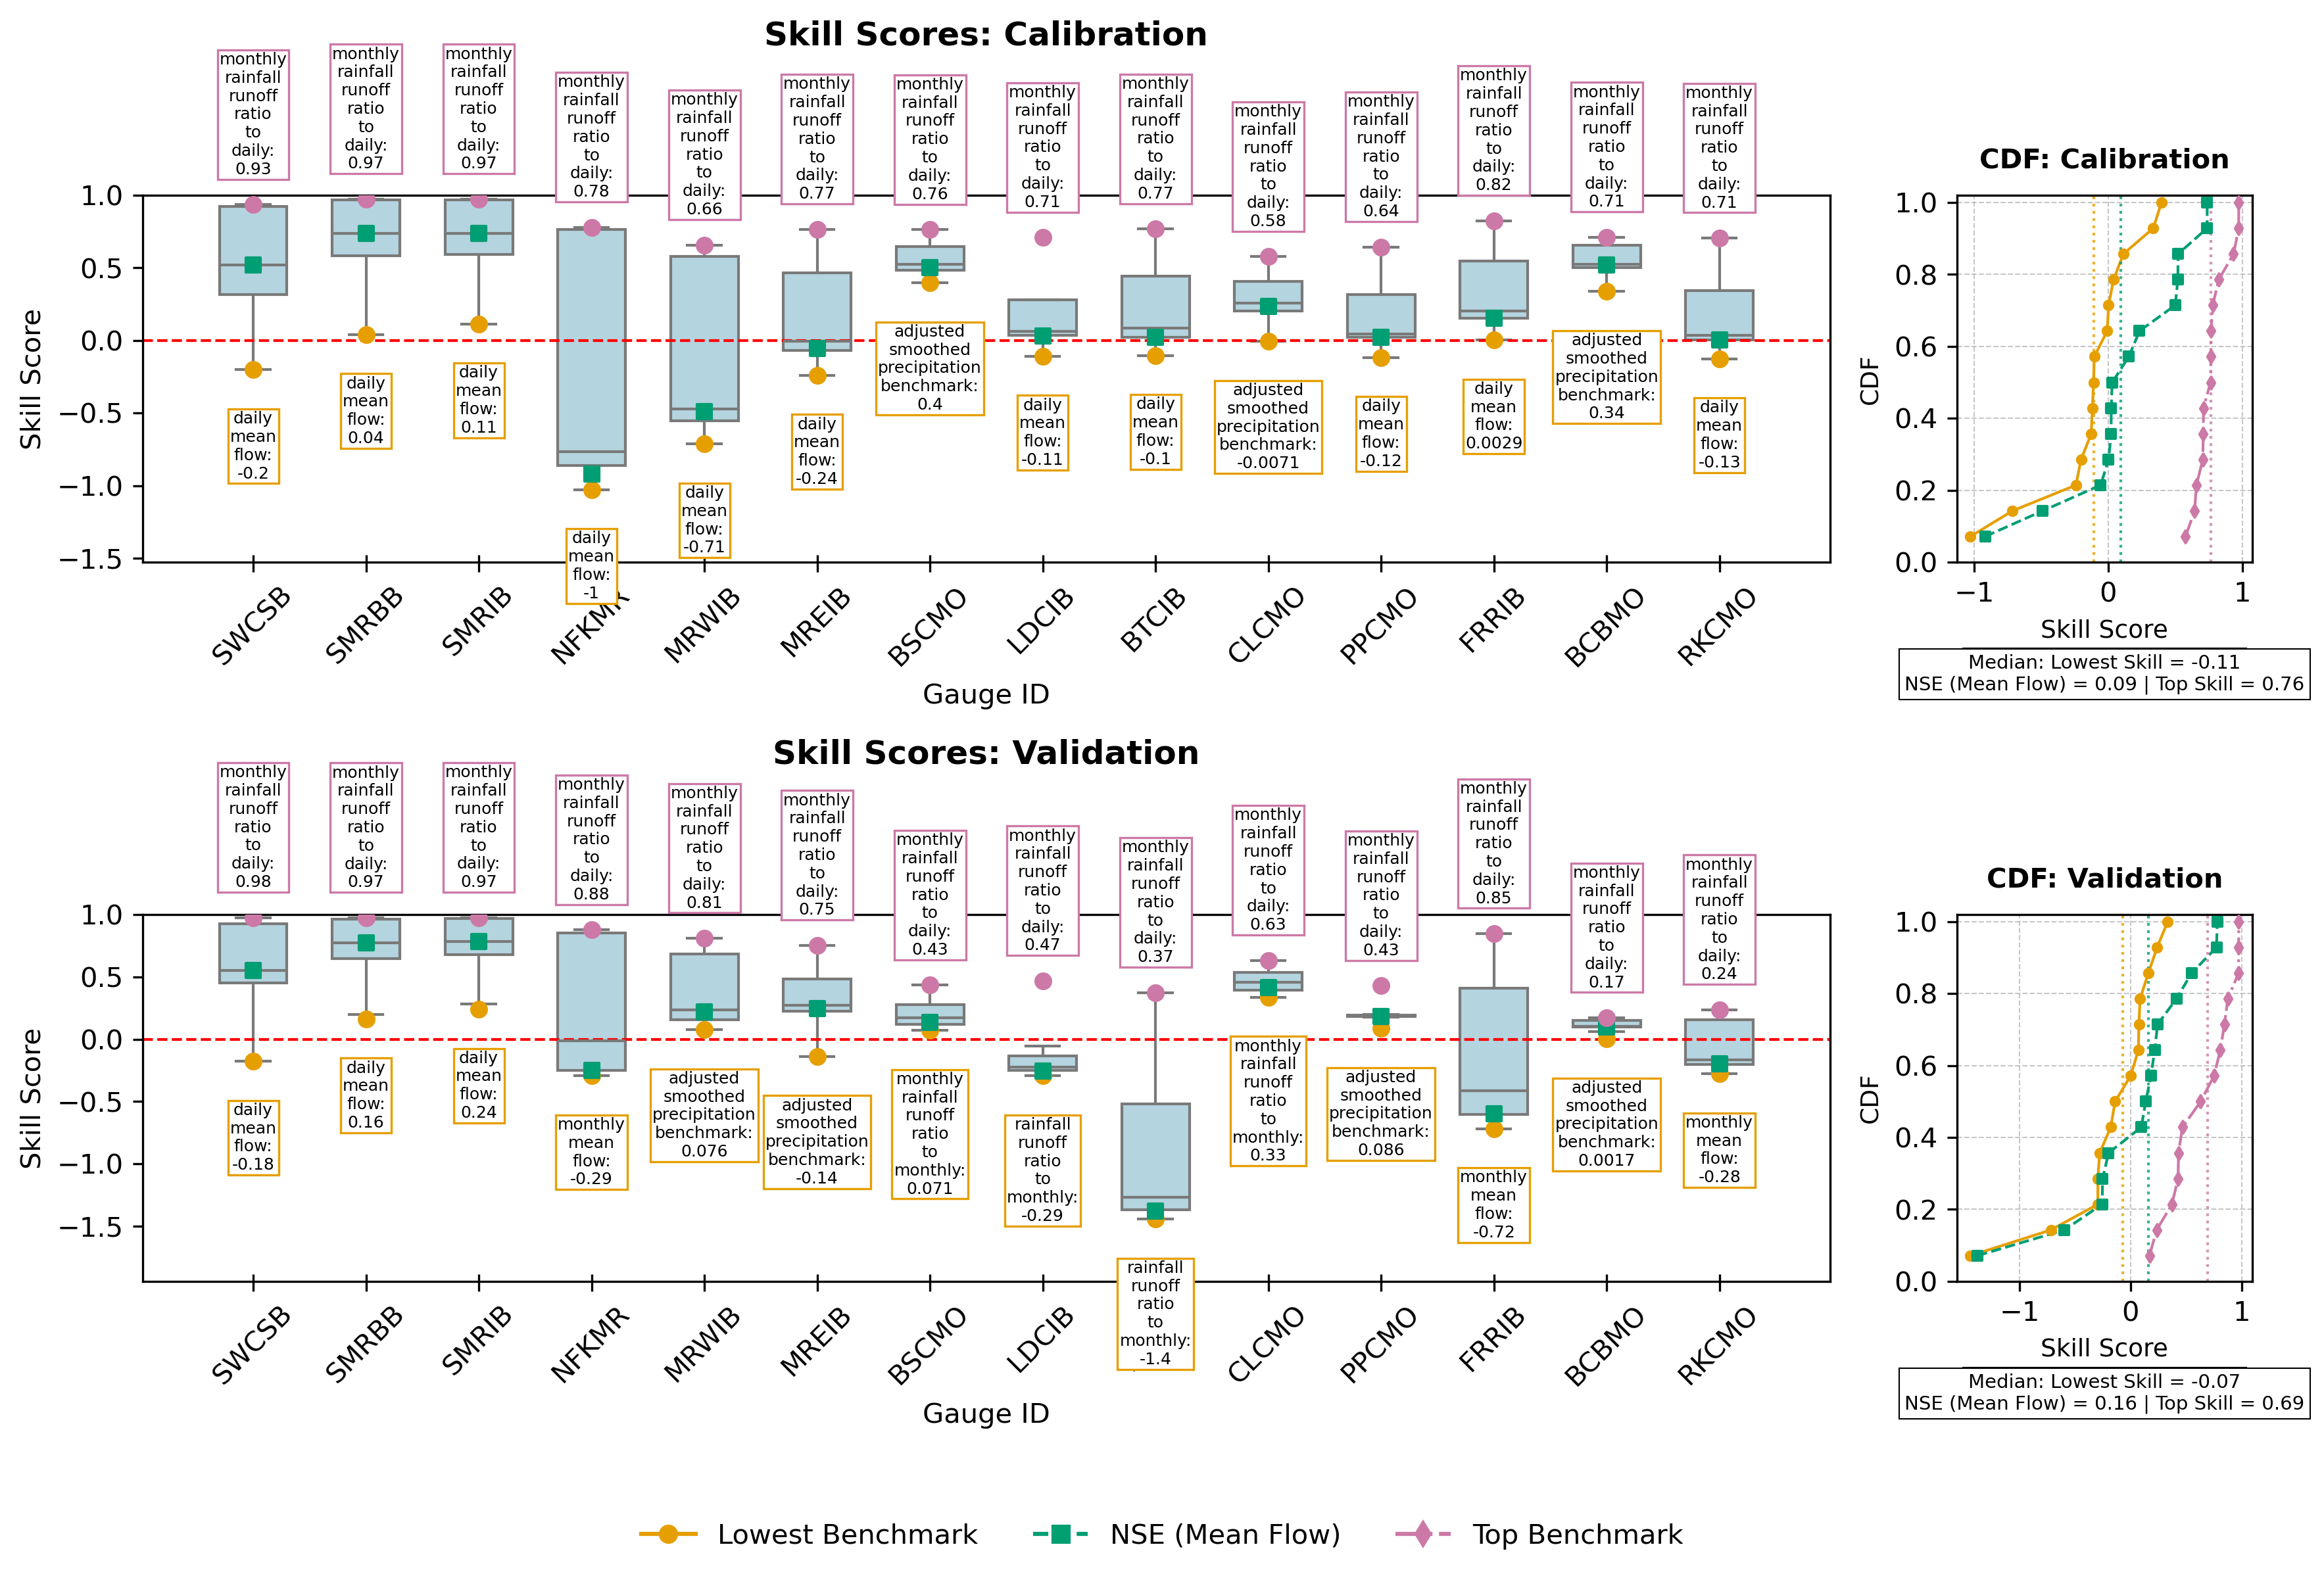

In [6]:
from matplotlib.gridspec import GridSpec

# CB-friendly colours
box_color = "#ADD8E6"  # lighter blue
lowest_benchmark_color = "#E69F00"  # orange
mean_flow_color = "#009E73"         # green
top_benchmark_color = "#CC79A7"  # magenta/purple

# Custom layout: 2 columns per row (boxplot + CDF)
fig = plt.figure(figsize=(12, 8), dpi=300)
gs = GridSpec(len(periods), 2, width_ratios=[4, 0.7], figure=fig)

axes_box = []
axes_cdf = []

for i, period in enumerate(periods):
    ax_box = fig.add_subplot(gs[i, 0])
    ax_cdf = fig.add_subplot(gs[i, 1])  # no sharey
    axes_box.append(ax_box)
    axes_cdf.append(ax_cdf)

    df_period = skill_scores_long[skill_scores_long['period'] == period].copy()
    df_period['gauge_id'] = pd.Categorical(
        df_period['gauge_id'],
        categories=df_period['gauge_id'].unique(),
        ordered=True
    )

    # -----------------
    # BOX PLOT
    # -----------------
    sns.boxplot(
        x='gauge_id', y='skill_score', data=df_period,
        ax=ax_box, color=box_color, width=0.6, fliersize=3
    )

    # Lowest benchmark
    min_rows = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmin()]
    x_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                   for gid in min_rows['gauge_id']]
    ax_box.scatter(x_positions, min_rows["skill_score"],
                   color=lowest_benchmark_color, s=30, zorder=5)

    # Mean flow (NSE benchmark)
    mean_rows = df_period[df_period['benchmark'] == 'bm_mean_flow']
    x_mean_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                        for gid in mean_rows['gauge_id']]
    ax_box.scatter(x_mean_positions, mean_rows["skill_score"],
                   color=mean_flow_color, s=30, zorder=5, marker='s')

    # Top benchmark
    max_rows = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmax()]
    x_max_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                       for gid in max_rows['gauge_id']]
    ax_box.scatter(x_max_positions, max_rows["skill_score"],
                   color=top_benchmark_color, s=30, zorder=5, marker='o')

    # Horizontal line
    ax_box.axhline(0, color='red', linestyle='--', linewidth=1)

    # Y limits
    y_min = df_period['skill_score'].min() - 0.5
    y_max = 1
    ax_box.set_ylim(y_min, y_max)

    # Annotations for lowest benchmark
    for row, x_pos in zip(min_rows.itertuples(), x_positions):
        label_text = row.benchmark.replace("bm_", "").replace("_", "\n")
        value_text = f"{row.skill_score:.2g}"
        ax_box.annotate(
            f"{label_text}:\n{value_text}",
            (x_pos, row.skill_score),
            textcoords="offset points", xytext=(0, -15), ha="center", va="top",
            fontsize=6, color="black",
            bbox=dict(facecolor='white', edgecolor=lowest_benchmark_color, linewidth=0.8, pad=0.7, alpha=1)
        )
    
    # Annotations for top benchmark
    for row, x_pos in zip(max_rows.itertuples(), x_max_positions):
        label_text = row.benchmark.replace("bm_", "").replace("_", "\n")
        value_text = f"{row.skill_score:.2g}"
        # choose color depending on whether it's top or mean
        edge_color = top_benchmark_color if row.benchmark != 'bm_mean_flow' else mean_flow_color
        ax_box.annotate(
            f"{label_text}:\n{value_text}",
            (x_pos, row.skill_score),
            textcoords="offset points", xytext=(0, 10), ha="center", va="bottom",
            fontsize=6, color="black",
            bbox=dict(facecolor='white', edgecolor=edge_color, linewidth=0.8, pad=0.7, alpha=1)
        )

    ax_box.set_title(f"Skill Scores: {period.capitalize()}", fontsize=12, weight='bold', pad=55)
    ax_box.set_ylabel("Skill Score", fontsize=10)
    ax_box.set_xlabel("Gauge ID", fontsize=10)
    ax_box.tick_params(axis="x", rotation=45)

    # Add little vertical lines above the x-axis labels
    for x in range(len(df_period['gauge_id'].cat.categories)):
        ax_box.vlines(x, ymin=y_min, ymax=y_min + 0.02*(y_max - y_min), color='black', linewidth=0.8)

    # -----------------
    # CDF PLOT
    # -----------------
    lowest_vals = min_rows["skill_score"].values
    mean_vals   = mean_rows["skill_score"].values
    top_vals    = max_rows["skill_score"].values
    
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(x) + 1) / len(x)
        return x, y
    
    median_texts = []
    
    for vals, color, label, ls, marker in [
        (lowest_vals, lowest_benchmark_color, "Lowest Skill", "-", "o"),
        (mean_vals, mean_flow_color, "NSE (Mean Flow)", "--", "s"),
        (top_vals, top_benchmark_color, "Top Skill", "-.", "d")
    ]:
        x, y = ecdf(vals)
        ax_cdf.plot(x, y, color=color, linestyle=ls, label=label, linewidth=1)
        ax_cdf.scatter(x, y, color=color, s=10, marker=marker, zorder=5)
    
        # --- Median vertical line ---
        if len(vals) > 0:
            median_val = np.median(vals)
            ax_cdf.axvline(median_val, color=color, linestyle=":", linewidth=1, alpha=0.8)
            median_texts.append((label, median_val, color))
    
        # --- Draw median text box once ---
        if median_texts:
            # Separate lowest median
            lower_label, lower_val, lower_color = median_texts[0]
            others = median_texts[1:]
            
            # Put line break **after lowest median only**
            label_text = f"Median: {lower_label} = {lower_val:.2f}\n"
            
            if others:
                label_text += " | ".join([f"{lbl} = {val:.2f}" for lbl, val, c in others])
            
            ax_cdf.text(
                0.5, -0.25, label_text,
                ha="center", va="top", transform=ax_cdf.transAxes,
                fontsize=7, color="black",
                bbox=dict(facecolor="white", edgecolor="black", linewidth=0.5, alpha=1, pad=2)
            )

    
    ax_cdf.set_title(f"CDF: {period.capitalize()}", fontsize=10, weight='bold', pad=10)
    ax_cdf.set_xlabel("Skill Score", fontsize=9)
    ax_cdf.set_ylabel("CDF", fontsize=9)
    ax_cdf.set_ylim(0, 1.02)
    ax_cdf.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Legend once for all
fig.legend(
    handles=[
        plt.Line2D([0], [0], color=lowest_benchmark_color, marker="o", label="Lowest Benchmark"),
        plt.Line2D([0], [0], color=mean_flow_color, linestyle="--", marker="s", label="NSE (Mean Flow)"),
        plt.Line2D([0], [0], color=top_benchmark_color, linestyle="-.", marker="d", label="Top Benchmark")
    ],
    loc="lower center", ncol=3, frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])

# Save figures
plt.savefig(os.path.join(output_dir, f'{plot_prefix}_skill_scores_boxplot.pdf'), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(output_dir, f'{plot_prefix}_skill_scores_boxplot.png'), dpi=300, bbox_inches="tight")

plt.show()
